In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np

# Clustering and Dimentionnality Reduction

<div class="alert alert-block alert-danger">

1. Import the CIFAR-10 dataset using the following code and create a new dataset containing only the following classes: "airplane," "automobile," "bird," and "cat."

<div/>

<div class="alert alert-block alert-warning">The CIFAR-10 dataset is composed of 60000 RGB images( 32x32 pixels), categorized into 10 classes with 6000 images per class. It is divided into 50000 training images and 10000 test images.
<div/>

In [7]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# summarize loaded dataset
print('train: X=%s, y=%s' % (x_train.shape, y_train.shape))

train: X=(50000, 32, 32, 3), y=(50000, 1)


In [8]:
print('test: X=%s, y=%s' % (x_test.shape, y_test.shape))

test: X=(10000, 32, 32, 3), y=(10000, 1)


<div class="alert alert-block alert-danger">

2. Visualize some samples from the dataset with their corresponding labels.

<div/>

In [9]:
target_classes = ['airplane', 'automobile', 'bird', 'cat']
target_indices = [label_names.index(cls) for cls in target_classes]

train_mask = np.isin(y_train, target_indices).flatten()
x_train_filtered = x_train[train_mask]
y_train_filtered = y_train[train_mask]

test_mask = np.isin(y_test, target_indices).flatten()
x_test_filtered = x_test[test_mask]
y_test_filtered = y_test[test_mask]

new_label_mapping = {index: i for i, index in enumerate(target_indices)}
y_train_filtered = np.vectorize(new_label_mapping.get)(y_train_filtered)
y_test_filtered = np.vectorize(new_label_mapping.get)(y_test_filtered)

In [10]:
def visualize_samples(images, labels, class_names, num_samples=16):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx][0]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

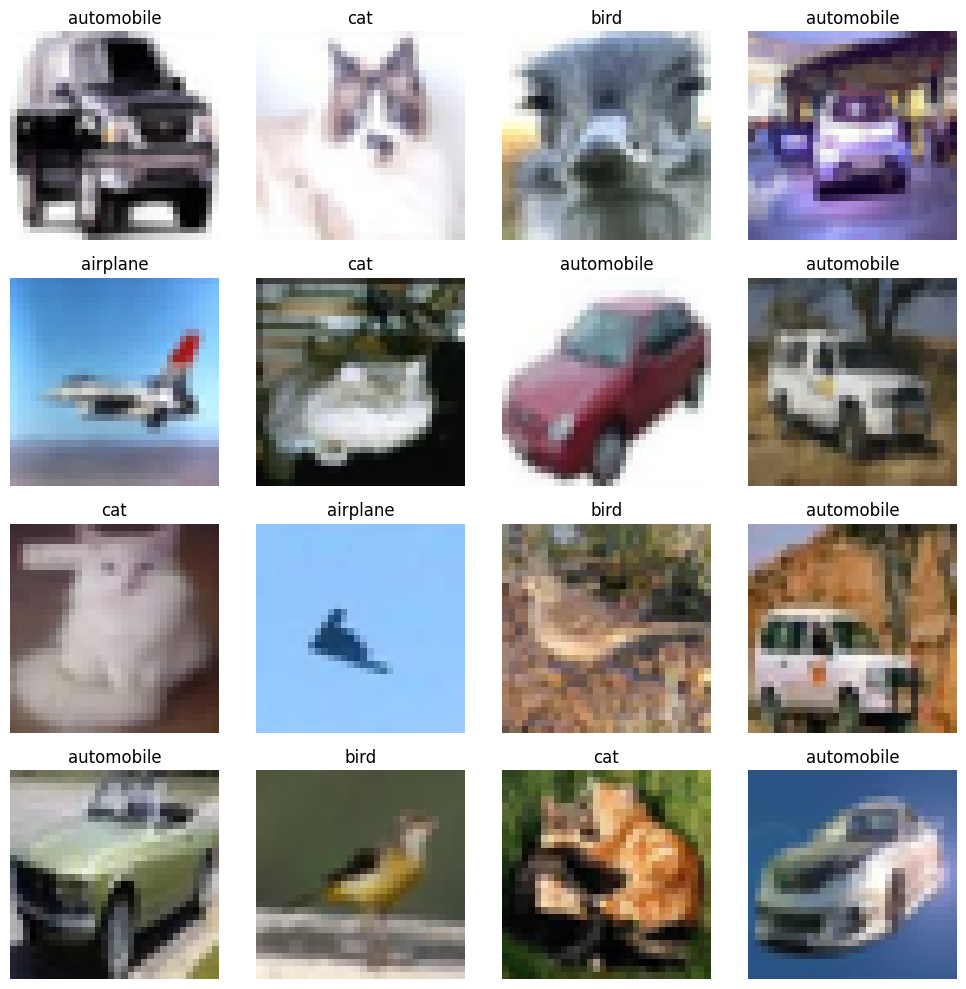

In [17]:
visualize_samples(x_train_filtered, y_train_filtered, target_classes)

<div class="alert alert-block alert-danger">

3. Normalize the training data by dividing all values by 255.

<div/>

In [12]:
print(f"min pixel value: {x_train_filtered.min()}")
print(f"max pixel value: {x_train_filtered.max()}")

min pixel value: 0
max pixel value: 255


In [13]:
x_train_filtered = x_train_filtered.astype('float32') / 255.0
x_test_filtered = x_test_filtered.astype('float32') / 255.0

print(f"min pixel value: {x_train_filtered.min()}")
print(f"max pixel value: {x_train_filtered.max()}")

min pixel value: 0.0
max pixel value: 1.0


<div class="alert alert-block alert-danger">

4. Visualize the data using a 2D plot by applying dimensionality reduction based on PCA with two components.

<div/>

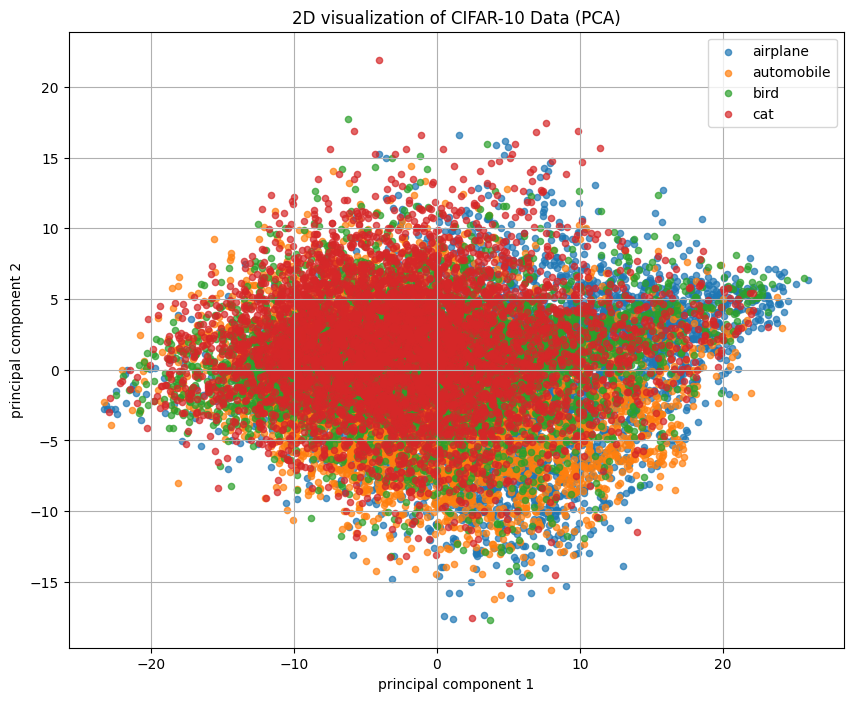

In [31]:
# PCA principal component analysis

# flatten the image data
x_train_flattened = x_train_filtered.reshape(x_train_filtered.shape[0], -1)

# apply PCA to reduce to 2 components
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_flattened)
x_test_pca = pca.transform(x_test_flattened)

# 2D scatter plot
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(target_classes))
for label in np.unique(y_train_filtered):
    idx = y_train_filtered.flatten() == label
    plt.scatter(
        x_train_pca[idx, 0], x_train_pca[idx, 1],
        label=target_classes[label],
        alpha=0.7,
        s=20
    )
plt.legend()
plt.title("2D visualization of CIFAR-10 Data (PCA)")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-danger">

5. Apply the K-means algorithm, K-means with PCA (with a variance of 95%), and K-means with LDA (3 components) on the normalized training data.

<div/>

In [30]:
x_train_flattened = x_train_filtered.reshape(x_train_filtered.shape[0], -1)
x_test_flattened = x_test_filtered.reshape(x_test_filtered.shape[0], -1)

x_train_flattened[0].shape

(3072,)

In [32]:
# k-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_train_flattened)

train_labels_kmeans = kmeans.predict(x_train_flattened)
test_labels_kmeans = kmeans.predict(x_test_flattened)

In [37]:
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_flattened)
x_test_pca = pca.transform(x_test_flattened)

kmeans_pca = KMeans(n_clusters=4, random_state=42)
kmeans_pca.fit(x_train_pca)

train_labels_kmeans_pca = kmeans_pca.predict(x_train_pca)
test_labels_kmeans_pca = kmeans_pca.predict(x_test_pca)

In [ ]:
# LDA linear discriminant analysis
lda = LinearDiscriminantAnalysis(n_components=3)
x_train_lda = lda.fit_transform(x_train_flattened, y_train_filtered.ravel())
x_test_lda = lda.transform(x_test_flattened)

kmeans_lda = KMeans(n_clusters=4, random_state=42)
kmeans_lda.fit(x_train_lda)

train_labels_kmeans_lda = kmeans_lda.predict(x_train_lda)
test_labels_kmeans_lda = kmeans_lda.predict(x_test_lda)

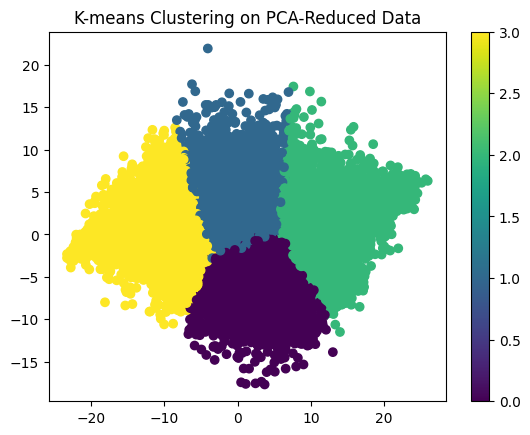

In [40]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=train_labels_kmeans_pca, cmap='viridis')
plt.title('K-means Clustering on PCA-Reduced Data')
plt.colorbar()
plt.show()


<div class="alert alert-block alert-danger">

6. Visualize the data after clustering using a 2D plot (use PCA with 2 components for dimensionality reduction) for each model. What do you observe?

<div/>

<div class="alert alert-block alert-danger">

7. Compute the Davies-Bouldin score for all generated models.

<div/>

<div class="alert alert-block alert-danger">

8. Display the confusion matrix and the classification reports for all models. What do you observe?

<div/>

<div class="alert alert-block alert-danger">

9. Display some misclassifications for the best model (image with the true label and predicted label).

<div/>

<div class="alert alert-block alert-danger">

10. Try to enhance the performance of the best model.

<div/>